### Project Definition (x)
Project Overview
Student provides a high-level overview of the project. Background information such as the problem domain, the project origin, and related data sets or input data is provided.

Problem Statement
The problem which needs to be solved is clearly defined. A strategy for solving the problem, including discussion of the expected solution, has been made.

Metrics
Metrics used to measure performance of a model or result are clearly defined. Metrics are justified based on the characteristics of the problem.




# Understanding YouTube Trends and Strategy for Going Viral

YouTube (the world-famous video sharing website) maintains a list of the top trending videos on the platform. Trending videos are not personalized and show what viewers in each country or region find interesting. For some videos it is predictable to become trending like a new song from a popular interpreter, or a new movie trailer. For other videos, the trends can be surprising. Within this notebook, we will explore trending videos and their YouTube titles with Natural Language Processing to build a machine learning model for an app that rates a new video title on a trending scale.

### Data set
To conduct the study, we used open data from [Kaggle](https://www.kaggle.com/datasnaek/youtube-new), which includes several months of collecting data on daily trending YouTube videos. The dataset contains information about many regions around the world, but we concentrate here on the US which has up to 200 listed trending videos per day.
This dataset was collected using the data scraper available on [Github](https://github.com/DataSnaek/Trending-YouTube-Scraper).


## Problem Statement: What decides if a video will be trending on YouTube?

YouTube remains vague about the patterns used in the trending algorithms and claims that some "soft facts" decide about trending. YouTube website says, that trending videos:

- are appealing to a wide range of viewers
- are not misleading, clickbaity, or sensational
- capture the breadth of what’s happening on YouTube and in the world
- showcase a diversity of creators
- ideally are surprising or novel.

According to YouTube, trending algorithm aims to balance these considerations. To achieve this goal, trending algorithm considers many factors, including, view count, how fast the video generates views (i.e. “temperature”), where views are coming from, including outside of YouTube and the age of the video.
Source: [YouTube Help Center](https://support.google.com/youtube/answer/7239739?hl=en). 

But what catches user's eye is at least the small thumbnail and the title text below the video. And even if YouTube is saying, clickbaity videos are not supported, while scrolling through YouTube trends everyone will find a lot of sensational and clickbaity results on the list.

Hard number metrics such as views or likes have likely to play a role, however it is not easy to discover how they are balanced and how they influence the overall trending ratings. 

## Metrics to measure viral videos

Even if YouTube does not openly admit, how the trending videos be found on the list, we will check how user interactions with videos  such as likes, views and comments influence the trending. Likes or dislikes produce immediate feedback, a lot of comments might be an evidence of having a large and engaged community. Getting many views drives the video up to the top of the trending list.
In this notebook, we will be studying how the title affects the trending, and we will lay grounds to develop an app, which check a new video title, if it is good enough for the video to become trending.

--------------------------------------------------  

### Analysis (x)

Data Exploration
Features and calculated statistics relevant to the problem have been reported and discussed related to the dataset, and a thorough description of the input space or input data has been made. Abnormalities or characteristics about the data or input that need to be addressed have been identified.

Data Visualization
Build data visualizations to further convey the information associated with your data exploration journey. Ensure that visualizations are appropriate for the data values you are plotting.



## 1. Importing relevant libraries. 

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.externals import joblib 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kasialukoszek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kasialukoszek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kasialukoszek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/kasialukoszek/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## 2. Loading and preprocessing data
We decide only to look into US video data. We drop several information such us ids, urls and dates not relevant for this notebook.

In [5]:
df = pd.read_csv("USvideos.csv")
df = df.drop(columns = ["description","video_id","publish_time","trending_date","thumbnail_link", "category_id"])
df.head()

,title,channel_title,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,SHANtell martin,748374,57527,2966,15954,False,False,False
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,False,False,False
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,False,False,False
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,False,False,False
4,I Dare You: GOING BALD!?,nigahiga,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,False,False,False


## 3. Quick Summaries about the Data

### 3.1 Top 10 YouTube Trending channels in the U.S.

In [3]:
df["channel_title"].value_counts().head(10)

ESPN                                      203
The Tonight Show Starring Jimmy Fallon    197
TheEllenShow                              193
Vox                                       193
Netflix                                   193
The Late Show with Stephen Colbert        187
Jimmy Kimmel Live                         186
Late Night with Seth Meyers               183
Screen Junkies                            182
NBA                                       181
Name: channel_title, dtype: int64

### 3.2 Top 10 Trending Tags in the U.S. 

In [4]:
def tokenize_tags(df):
    flatten_tags = df["tags"].iloc[:10].str.lower().str.cat(sep=' ')
    tags_cleaned = re.sub('[^A-Za-z]+', ' ', flatten_tags)
    tokens = word_tokenize(tags_cleaned)
    lemmatizer = WordNetLemmatizer()
    default_stopwords = set(stopwords.words("english"))
    tokens = [w for w in tokens if w not in default_stopwords]
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
    return clean_tokens

In [5]:
cleaned_data_title = tokenize_tags(df)
list = pd.Series(cleaned_data_title)
list.value_counts().head(10)

gadget        8
nickelback    8
iphone        6
mythical      5
x             5
musical       5
trailer       5
barnum        4
music         4
trump         4
dtype: int64

### 3.3 Correlations of the numerical data in the dataset.
Looking at correlations ist one of the first ways to understand the data better. Even if a correlation between two variables does not automatically mean the causation between variables, it might gives hints for a further analysis.

In our correlation matrix we observe strong correlations between views, likes, dislikes an comment_count. 

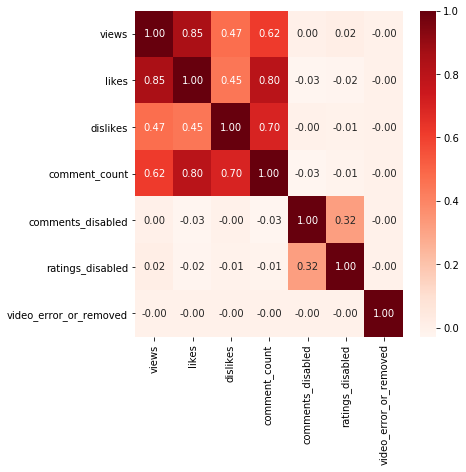

In [6]:
plt.figure(figsize=(6,6))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt=".2f")
plt.show()

### 3.4 The distribution of the numerical variables

To get some information about numerical variables, we first look into the descriptive statistics.

In [7]:
df.describe()

,views,likes,dislikes,comment_count
count,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


To create a new measure, we should compare the distribution of the numerical variables in the dataset. Obviously we have some outliers, so taking the natural log of a value can reduce the variation caused by extreme values. 

In [8]:
df["views_log"] = np.log(df["views"] + 1)
df["likes_log"] = np.log(df["likes"] + 1)
df["dislikes_log"] = np.log(df["dislikes"] + 1)
df["comment_count_log"] = np.log(df["comment_count"] + 1)

After we have applied the transformations, we check the distributions graphs

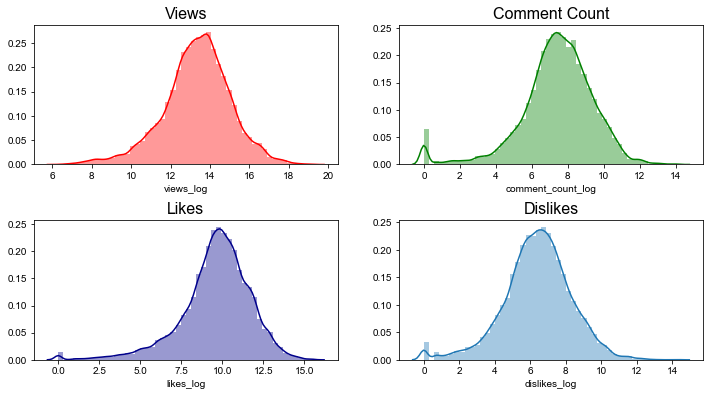

In [9]:
plt.figure(figsize = (12,6))

plt.subplot(221)
views_plot = sns.distplot(df["views_log"], color="red")
views_plot.set_title("Views", fontsize=16)

plt.subplot(222)
comment_plot = sns.distplot(df["comment_count_log"], color="green")
comment_plot.set_title("Comment Count", fontsize=16)

plt.subplot(223)
likes_plot = sns.distplot(df["likes_log"], color="darkblue")
likes_plot.set_title("Likes", fontsize=16)

plt.subplot(224)
dislikes_plot = sns.distplot(df["dislikes_log"])
dislikes_plot.set_title("Dislikes", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

sns.set()
sns.set_color_codes("dark")
plt.show()

## 4. Creating a new measure "viral index"
After looking into data, we try to determine what could control the trending probability (we call it "viral index"). After some research, we define the viral index as a logarithm of the sum of views, likes and comment counts minus 2 factor dislikes, devided by the highest rank. We weighted dislikes more, because dislikes are havier than the number of positive likes. According to the [Verge](https://www.theverge.com/2019/2/1/18207189/youtube-dislike-attack-mob-review-bomb-creator-insider) "Reports have suggested that a video with a high number of dislikes — that outweighs the number of positive likes — is less likely to be recommended, and could therefore hurt the creator".
Likes and views seem to have a strong correlation with each other, so we might renounce to weight the likes stronger than views. Similar applies to the comments. After we sum up the variables, we apply the logarithm to handle the outliers.

In [10]:
highest_rank = (df["views"] + (df["likes"] - 2* df["dislikes"]) +  df["comment_count"]).sort_values(ascending=False).iloc[0]

In [11]:
df["viral_index"] = np.log((df["views"] + (df["likes"] - 2* df["dislikes"]) +  df["comment_count"]) / highest_rank)

In [12]:
df["viral_index"].head(10)

0   -5.641799
1   -4.515543
2   -4.233900
3   -6.476388
4   -4.631216
5   -7.483559
6   -4.688605
7   -5.608831
8   -5.625050
9   -6.752442
Name: viral_index, dtype: float64

In [13]:
df["viral_index"].describe()

count    40949.000000
mean        -5.881301
std          1.711087
min        -12.920595
25%         -6.815322
50%         -5.789953
75%         -4.802419
max          0.000000
Name: viral_index, dtype: float64

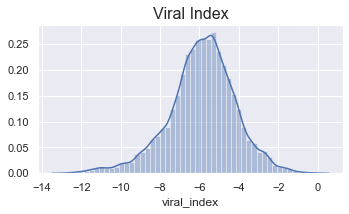

In [14]:
plt.figure(figsize = (12,6))
plt.subplot(221)
g1 = sns.distplot(df["viral_index"])
g1.set_title("Viral Index", fontsize=16)
sns.set()
sns.set_color_codes("dark")

In [15]:
df.sort_values(by="viral_index", ascending=False).head(10)["title"]

38547    Childish Gambino - This Is America (Official V...
38345    Childish Gambino - This Is America (Official V...
38146    Childish Gambino - This Is America (Official V...
37935    Childish Gambino - This Is America (Official V...
37730    Childish Gambino - This Is America (Official V...
37531    Childish Gambino - This Is America (Official V...
37333    Childish Gambino - This Is America (Official V...
37123    Childish Gambino - This Is America (Official V...
36913    Childish Gambino - This Is America (Official V...
36710    Childish Gambino - This Is America (Official V...
Name: title, dtype: object

### Results

Model Evaluation and Validation
If a model is used, the following should hold: The final model’s qualities — such as parameters — are evaluated in detail. Some type of analysis is used to validate the robustness of the model’s solution.

Alternatively a student may choose to answer questions with data visualizations or other means that don't involve machine learning if a different approach best helps them address their question(s) of interest.

Justification
The final results are discussed in detail.
Exploration as to why some techniques worked better than others, or how improvements were made are documented.



## 5. Design a machine learning model based on natural language processing
Here we create our model using the new metric viral index. we take the raw title of a youtube video, clean it, normalize it, and convert it into a form that is suitable for the word embeddings. Word embeddings are vector representations of a particular word. After that we put the word embeddings to a the machine learning model, fit its parameters to training data, and use an optimization procedure. At the end, we save the model to a pickle format to use it to make predictions about unseen data later in our app.

In [16]:
# define X and Y data sets
X = df["title"]
Y = df["viral_index"]

In [17]:
# create the text processing function
def tokenize(text):
    text = re.sub(r"[^a-zA-Z0-9]", " ", str(text))
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    default_stopwords = set(stopwords.words("english"))
    tokens = [w for w in tokens if w not in default_stopwords]
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [18]:
#create a pipeline for the machine learning model
pipeline =  Pipeline([
    ('vect', CountVectorizer(tokenizer = tokenize)),
    ('tfidf', TfidfTransformer()),
    ('predictor', SVR(kernel ="rbf", gamma='scale', C=1.0, epsilon=0.2))
])

In [19]:
#divide the data into testing and training set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 42)
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x1a2b27fe18>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('predictor',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
     

In [21]:
# check an Youtube title, if the model predicts any value.
msg = ["YouTube Rewind: The Shape of 2017 | #YouTubeRe..."]
pipeline.predict(msg)

array([-4.27965595])

In [22]:
# create parameters for an optimization procedure
parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'tfidf__use_idf': [True, False],
        'tfidf__norm': ['l1', 'l2']
        }
# optimize model
model = GridSearchCV(pipeline, param_grid=parameters, cv=2, verbose=1, n_jobs=4)
model.fit(X_train, Y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:  5.5min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [24]:
#use the model to predict the values
y_pred = model.predict(X_test)
y_pred.item(1)

In [26]:
# check the model metrics
print(model.score(X_test,Y_test))
print(r2_score(Y_test,y_pred))

0.8407424098419297
0.8407424098419297


In [27]:
# save the model to disk
joblib.dump(model, 'model.pkl') 

['model.pkl']

## 6. Prepering the results for the app and saving into database
To prepare the results for the app, we devide the results into four equal-sized groups using quantiles. With the four groups we create a four steps scale. To each quantile, we assign a name "bad < ok < promising < superior". Later we use the 4 quantiles to make predictions about unseen data in our app.

In [30]:
result = pd.DataFrame()
result["X"] = X
result["Y"] = Y
result["Y_pred"] = pipeline.predict(X)

In [31]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///USvideos.db')
result.to_sql("trends_data", engine, index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2b9b4710>,
      dtype=object)

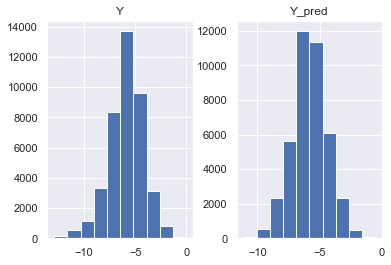

In [33]:
result.hist(bins=10)

In [35]:
def create_labels():
    labels = ["bad", "ok", "promising", "superior"]
    return labels

def create_bins(df):
    limit0 = df["Y_pred"].quantile([.0]).iloc[0]
    limit25 = df["Y_pred"].quantile([.25]).iloc[0]
    limit50 = df["Y_pred"].quantile([.5]).iloc[0]
    limit75 = df["Y_pred"].quantile([.75]).iloc[0]
    bins = [limit0, limit25, limit50, limit75, np.inf]
    return bins

In [39]:
predicted_value = model.predict(["My new YouTube Video about Fallout"])
labels = create_labels()
bins = create_bins(result)
# create a label based on quantile value
pd.cut(predicted_value, bins, labels=labels)[0]

'promising'

# Conclusion

## Reflection
Student adequately summarizes the end-to-end problem solution and discusses one or two particular aspects of the project they found interesting or difficult.

## Improvement
Discussion is made as to how at least one aspect of the implementation could be improved. Potential solutions resulting from these improvements are considered and compared/contrasted to the current solution.



## Limitations and further research
Unfortunately YouTube trending algorithm is not public. Hence we could only make assumptions to what extent user interactions are part of it.

In this notebook, we will be studying only the title of the video. The data also contains the thumbnail of the trending video. Possible further analyses could include the image classification, if the data also could derive any information about the trends.